In [1]:

import numpy as np
import torch
from config import CONFIG
from dataset import XRR1LayerDataset
from model import XRR1DRegressor

# -------------------------------------------------------------
# 기본 세팅
# -------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용 장치: {device}")

exp_dir = CONFIG["base_dir"] / CONFIG["exp_name"]
h5_file = exp_dir / "dataset.h5"
stats_file = exp_dir / "stats.pt"
checkpoint_file = exp_dir / "best.pt"

# -------------------------------------------------------------
# 모델 생성 및 가중치 로드
# -------------------------------------------------------------
model = XRR1DRegressor(
    q_len=CONFIG["simulation"]["q_points"],
    n_channels=CONFIG["model"]["n_channels"],
    depth=CONFIG["model"]["depth"],
    mlp_hidden=CONFIG["model"]["mlp_hidden"],
    dropout=CONFIG["model"]["dropout"],
).to(device)

checkpoint = torch.load(checkpoint_file, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

# -------------------------------------------------------------
# 정규화 파라미터 로드
# -------------------------------------------------------------
dummy_dataset = XRR1LayerDataset(h5_file, stats_file, mode="test", val_ratio=CONFIG["training"]["val_ratio"])
refl_mean = dummy_dataset.refl_mean
refl_std = dummy_dataset.refl_std
param_mean = dummy_dataset.param_mean
param_std = dummy_dataset.param_std

사용 장치: cuda


thicknesses: [62.20760352], roughnesses: [1.46358373], slds: [7.952772]


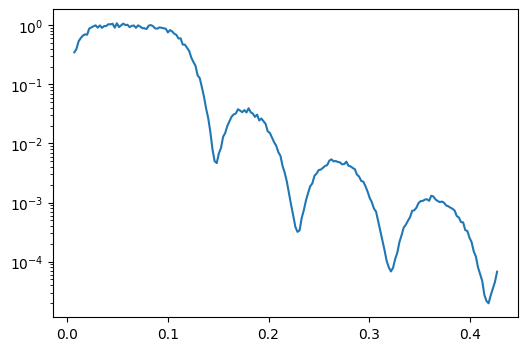

In [2]:
import matplotlib.pyplot as plt

from reflecto.simulate.simul_genx import XRRSimulator, tth2q_wavelen

wavelen: float = 1.54  # (nm)
tth_min: float = 0.1   # degree
tth_max: float = 6.0
tth_n: int = 200
tths: np.ndarray = np.linspace(tth_min, tth_max, tth_n)
qs: np.ndarray = tth2q_wavelen(tths, wavelen)

xrr_simulator = XRRSimulator(qs, 1, 1)
thicknesses, roughnesses, slds, refl = next(xrr_simulator.make_params_refl())

print(f"thicknesses: {thicknesses}, roughnesses: {roughnesses}, slds: {slds}")

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(qs, refl)
ax.set_yscale("log")

plt.show()

In [3]:
# -------------------------------------------------------------
# 1️⃣ 실험 Reflectivity 정규화 → 모델 입력 준비
# -------------------------------------------------------------
R_norm = dummy_dataset.normalize_reflectivity(refl)        # (q_len,)
x = R_norm.unsqueeze(0).unsqueeze(0).to(device)            # (1, 1, q_len)

# -------------------------------------------------------------
# 2️⃣ 모델 추론 (정규화된 파라미터)
# -------------------------------------------------------------
with torch.no_grad():
    y_pred_norm = model(x).squeeze().cpu().numpy()         # (3,)

# -------------------------------------------------------------
# 3️⃣ 역정규화 → 실제 물리 파라미터
# -------------------------------------------------------------
y_pred = dummy_dataset.denormalize_params(y_pred_norm)
thickness_pred, roughness_pred, sld_pred = y_pred

print(f"predicted: {thickness_pred}, {roughness_pred}, {sld_pred}")
print(f"true: {thicknesses}, {roughnesses}, {slds}")

predicted: 58.361820220947266, -0.43693047761917114, 7.088559627532959
true: [62.20760352], [1.46358373], [7.952772]


predicted: 58.361820220947266, -0.43693047761917114, 7.088559627532959
true: [62.20760352], [1.46358373], [7.952772]
FOM log: 0.02771469252002845 nan 0.049960548901977764


D:\02_Projects\Dev\X-ray_AI\Reflecto\src\reflecto\math_utils.py:6: RuntimeWarning: invalid value encountered in log10
  return np.mean(np.abs(np.log10(ref_exp) - np.log10(ref_calc)))


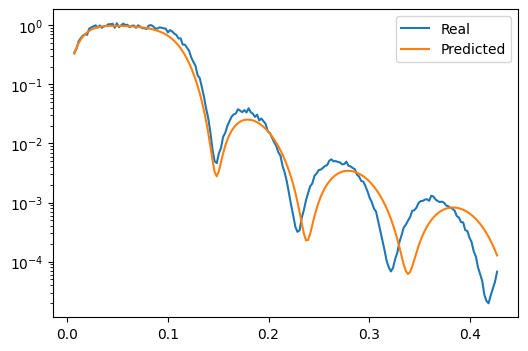

In [4]:
from reflecto.math_utils import fom_log
from reflecto.simulate.simul_genx import ParamSet, build_sample, calc_refl

pred_params = [ParamSet(thickness_pred, roughness_pred, sld_pred)]
sample = build_sample(pred_params)
pred_refl = calc_refl(sample, qs)

print(f"predicted: {thickness_pred}, {roughness_pred}, {sld_pred}")
print(f"true: {thicknesses}, {roughnesses}, {slds}")
print(f"FOM log: {fom_log(thicknesses, thickness_pred)} {fom_log(roughnesses, roughness_pred)} {fom_log(slds, sld_pred)}")
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(qs, refl, label="Real")
ax.plot(qs, pred_refl, label="Predicted")

ax.legend()
ax.set_yscale("log")

plt.show()

In [5]:
import pandas as pd

data = pd.DataFrame({"# qs": qs, "refl": refl})

data.to_csv("data.csv", index=False, sep="\t")

In [7]:
import numpy as np
from genx.data import DataList, DataSet
from genx.diffev import DiffEv
from genx.model import Model
from genx.model_control import ModelController
from genx.models.lib import Layer, Material

data = DataList()
dataset = DataSet()
dataset.set_data(x=qs, y=refl, error=refl*0.03)  # 3% error 가정 (필요시 조정)
dataset.name = "In2O3 on SiO2/Si"
data.append(dataset)

# 2. 컨트롤러 + 옵티마이저 생성
optimizer = DiffEv()
controller = ModelController(optimizer)
controller.set_data(data)

# 3. 완벽한 모델 스크립트 (In2O3 / SiO2 / Si 구조 전용)
controller.set_model_script("""
import numpy as np
from genx.reflections import Reflectivity
from genx.core.parameters import Layer, Material

# 부드러운 계면을 위한 erfc 함수 (roughness 완벽 구현)
def erf(x):
    # numpy의 erf를 사용
    return np.erf(x)

def smooth_interface(d, z0, z1, sigma):
    if sigma <= 0.01:
        return np.heaviside(d - z0, 1) * (1 - np.heaviside(d - z1, 1))
    else:
        return (erf((d - z0)/(sigma*np.sqrt(2))) - erf((d - z1)/(sigma*np.sqrt(2)))) / 2 + 0.5

def Sample(layers, d):
    sld = np.zeros_like(d)
    
    # Si substrate (무한 thick)
    sld += layers[0].material.sld[0] * (d < layers[0].d + 50)  # +50은 safety
    
    # SiO2 layer
    z1 = layers[0].d + 50
    z2 = z1 + layers[1].d
    sld += layers[1].material.sld[0] * smooth_interface(d, z1, z2, layers[1].sigma)
    
    # In2O3 layer
    z3 = z2 + layers[2].d
    sld += layers[2].material.sld[0] * smooth_interface(d, z2, z3, layers[2].sigma)
    
    # Air (위쪽은 항상 0)
    sld += layers[3].material.sld[0] * (d >= z3)
    
    return sld

def Model(x, layers):
    # Ambient (Air)
    ambient = Layer(material=Material(sld=0.0), d=0.0, sigma=layers[2].sigma)
    
    # 실제 층 순서: Air | In2O3 | SiO2 | Si
    stack = [ambient, layers[2], layers[1], layers[0]]
    
    # SLD 프로파일 계산 (0~2000Å까지)
    d = np.linspace(0, 2000, 3000)
    sld_profile = Sample(layers, d)
    
    return Reflectivity(x, stack, sld_profile)
""")

# 4. 층 정의 (당신이 원하는 초기값으로 설정)
Si     = Layer(Material(sld=2.07e-6, name="Si"),     d=0,      sigma=3.0,  name="Si substrate")
SiO2   = Layer(Material(sld=3.47e-6, name="SiO2"),   d=20.0,   sigma=5.0,  name="SiO2")
In2O3  = Layer(Material(sld=5.70e-6, name="In2O3"),  d=800.0,  sigma=8.0,  name="In2O3")  # In2O3 SLD ≈ 5.7
Air    = Layer(Material(sld=0.0,     name="Air"),    d=0,      sigma=5.0,  name="Air")

# 5. 모델에 층 추가
model = Model()
model.data = data
model.layers = [Si, SiO2, In2O3, Air]
controller.set_model(model)

# 6. 피팅 파라미터 설정 (체크박스 켜는 것과 동일)
params = controller.get_parameters()
# 예: In2O3 두께, SLD, roughness + SiO2 두께 피팅
params.set_value(2, 0, True)   # In2O3 fit 체크
params.set_value(2, 1, True)   # In2O3.d fit
params.set_value(2, 2, True)   # In2O3.sld fit
params.set_value(2, 4, True)   # In2O3.sigma fit

params.set_value(1, 1, True)   # SiO2.d fit
params.set_value(1, 4, True)   # SiO2.sigma fit

controller.set_model_params(params)

# 7. 피팅 시작! (DE 기본값으로 매우 잘 맞음)
controller.StartFit()

# 8. 피팅 끝나면 결과 확인
print("최종 FOM:", controller.get_fom())
print("In2O3 두께:", controller.get_parameters().data[2][1])
print("In2O3 SLD:", controller.get_parameters().data[2][2])
print("In2O3 roughness:", controller.get_parameters().data[2][4])

'Plugin' object has no attribute 'data'


ImportError: cannot import name 'Layer' from 'genx.models.lib' (d:\02_Projects\Dev\X-ray_AI\Reflecto\.venv\Lib\site-packages\genx\models\lib\__init__.py)